In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import sys
from types import MethodType
from pipeline import experiment_pipeline
from preprocessing import load_data

random.seed(10)

arguments = sys.argv

arguments = [0, '/home/tristan/Desktop/Repos/DreamHF']
ROOT = arguments[1]

print("Loading the data...")
pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test = load_data(
    ROOT)


/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.Criterion size changed, may indicate binary incompatibility. Expected 328 from C header, got 528 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 1160 from C header, got 1360 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.ClassificationCriterion size changed, may indicate binary incompatibility. Expected 1168 from C header, got 1368 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.RegressionCriterion size changed, may indicate binary incompatibility. Ex

Loading the data...


In [3]:
import os
import pathlib

import numpy as np
import pandas as pd
import sklearn
from sksurv.metrics import concordance_index_censored
sklearn.set_config(transform_output="pandas")

import wandb
from model_evaluation import evaluate_model
from preprocessing import CLINICAL_COVARIATES, Salosensaari_processing, clr_processing

sklearn.set_config(transform_output="pandas")

In [4]:
processing = 'MI_clr'
clinical_covariates = ['Age',
                       'BodyMassIndex',
                       'Smoking',
                       'BPTreatment',
                       'PrevalentDiabetes',
                       'PrevalentCHD',
                       #'PrevalentHFAIL',
                       'SystolicBP',
                       'NonHDLcholesterol',
                       'Sex']  # CLINICAL_COVARIATES


#clinical_covariates= CLINICAL_COVARIATES
n_taxa = 0

if processing == 'Salosensaari':
    X_train, X_test, y_train, y_test, test_sample_ids, train_sample_ids = Salosensaari_processing(
        pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test, clinical_covariates
    )
elif processing == 'MI_clr':
    ## Feature selection
    X_train, X_test, y_train, y_test, test_sample_ids, train_sample_ids = clr_processing(
        pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test, clinical_covariates,  n_taxa)


In [6]:
X_train

Unnamed: 0,Age,PrevalentCHD,adiv
Simulated_328,53.618,0,2078.0
Simulated_1644,36.811,0,771.0
Simulated_1710,49.429,0,1680.0
Simulated_1732,48.842,0,2039.0
Simulated_1727,60.738,0,1822.0
...,...,...,...
Simulated_1783,33.802,0,2299.0
Simulated_3425,69.249,0,1823.0
Simulated_1789,28.561,0,1468.0
Simulated_1592,70.278,0,1638.0


In [9]:
root = ROOT
outdir = root + "/output/"
risk_scores_train = pd.read_csv(outdir + "scores_train.csv")
risk_scores_train = risk_scores_train.set_index('SampleID')
harrell_C_training = concordance_index_censored(
    y_train['Event'], y_train['Event_time'], risk_scores_train.Score)[0]

result = {
    "Harrell C": [harrell_C_training]
}

print(pd.DataFrame(result, index=["train"]))


risk_scores = pd.read_csv(outdir + "scores.csv")
risk_scores = risk_scores.set_index('SampleID')

       Harrell C
train   0.716123


In [25]:
any(risk_scores.isna().Score)

False

In [26]:
any(risk_scores.isna())

True

In [15]:
any(risk_scores.isna())


True

In [27]:
any(risk_scores.Score < 0) or any(risk_scores.Score >1) or any(risk_scores.isna().Score)

False

In [24]:
from sklearn.feature_selection import RFECV
from survival_models import CoxPH, sksurv_gbt
from sklearn.model_selection import RepeatedKFold
min_features_to_select = 1  # Minimum number of features to consider    
model = CoxPH(0)
cv = RepeatedKFold(n_splits = 2, n_repeats = 1)

features = np.intersect1d(clinical_covariates, X_train.columns)
other_features = np.setxor1d(clinical_covariates, X_train.columns)
rfecv = RFECV(
    estimator=model.pipeline[1],
    step=1,
    cv=cv,
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
    verbose = 0
)
rfecv.fit(model.pipeline[0].fit_transform(X_train.loc[:,features], y_train), y_train)
features = [el.rsplit('__')[1] for el in rfecv.get_feature_names_out()]
output = np.union1d(features, other_features)

In [25]:
output

array(['Age', 'PrevalentCHD', 'adiv', 'shannon'], dtype=object)

In [19]:
X_train.columns


Index(['Age', 'BodyMassIndex', 'Smoking', 'BPTreatment', 'PrevalentDiabetes',
       'PrevalentCHD', 'SystolicBP', 'NonHDLcholesterol', 'Sex', 'adiv',
       'shannon'],
      dtype='object', name='Unnamed: 0')

In [18]:
clinical_covariates

['Age',
 'BodyMassIndex',
 'Smoking',
 'BPTreatment',
 'PrevalentDiabetes',
 'PrevalentCHD',
 'SystolicBP',
 'NonHDLcholesterol',
 'Sex']

In [22]:
other_features = np.setxor1d(clinical_covariates, X_train.columns)

In [23]:
other_features


array(['adiv', 'shannon'], dtype=object)

In [17]:
features


['Age', 'PrevalentCHD', 'Smoking']

In [10]:
features

['Age', 'PrevalentCHD']

In [9]:
X_train


Unnamed: 0,Age,BodyMassIndex,Smoking,BPTreatment,PrevalentDiabetes,PrevalentCHD,SystolicBP,NonHDLcholesterol,Sex,adiv,shannon
Simulated_328,53.618,24.127,0,0,0,0,133.077,3.02,0,2078.0,5.281002
Simulated_1644,36.811,27.992,0,0,0,0,108.914,5.48,0,771.0,2.838381
Simulated_1710,49.429,23.664,0,0,0,0,110.064,4.388,1,1680.0,3.884434
Simulated_1732,48.842,26.804,0,0,0,0,128.059,5.119,0,2039.0,4.964998
Simulated_1727,60.738,29.862,0,0,0,0,169.913,5.74,1,1822.0,5.505621
...,...,...,...,...,...,...,...,...,...,...,...
Simulated_1783,33.802,37.049,0,0,0,0,109.08,3.141,0,2299.0,5.140628
Simulated_3425,69.249,36.8,0,0,1,0,145.953,5.478,1,1823.0,5.738824
Simulated_1789,28.561,26.463,0,0,0,0,124.091,4.87,1,1468.0,5.318359
Simulated_1592,70.278,31.945,0,1,0,0,142.038,2.492,0,1638.0,5.306464


## RFECV

In [7]:
from sklearn.feature_selection import RFECV
from survival_models import CoxPH, sksurv_gbt
from sklearn.model_selection import RepeatedKFold
min_features_to_select = 1  # Minimum number of features to consider
 
model = CoxPH(0)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1)

rfecv = RFECV(
    estimator=model.pipeline[1],
    step=1,
    cv=cv,
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
    verbose = 10
)
rfecv.fit(model.pipeline[0].fit_transform(X_train.loc[:,clinical_covariates], y_train), y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 8 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 5 features.
Fitting estimator with 7 features.
Fitting estimator with 3 features.
Fitting estimator with 3 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator wi

In [8]:
rfecv.get_feature_names_out()

array(['num__Age', 'cat__PrevalentCHD'], dtype=object)

In [12]:
sentence = 'b a hello b Hi'
[el.rsplit('__')[1] for el in rfecv.get_feature_names_out()]

['Age', 'PrevalentCHD']

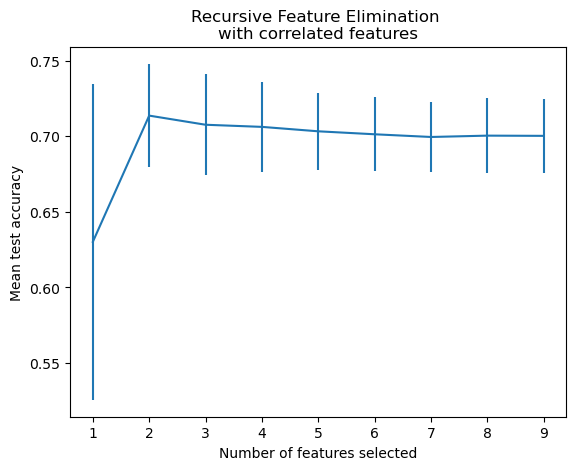

In [73]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


## Genomic features selection

In [58]:
from preprocessing import relative_abundance
from sklearn.feature_selection import SelectKBest
event_df = pheno_df_train['Event']
threshold = 1e-5
proportions_df=relative_abundance(readcounts_df_train)
presence_df=proportions_df >= threshold

kbest = SelectKBest(
    sklearn.feature_selection.mutual_info_classif, k=n_taxa)

kbest.fit(presence_df, event_df)
kbest.get_feature_names_out()

[autoreload of pipeline failed: Traceback (most recent call last):
  File "/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/tristan/Desktop/Repos/DreamHF/src/pipeline.py", line 40
    def

array(['k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halopenitus;s__Halopenitus_sp._DYS4',
       'k__Bacteria;p__Acidobacteria;c__Holophagae;o__Holophagales;f__Holophagaceae;g__Holophaga;s__Holophaga_foetida',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum;s__Varibaculum_cambriense',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia_aichiensis',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Brachybacterium;s__Brachybacterium_faecium',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Tetrasphaera;s__Tetrasphaera_australiensis',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium_azadirachtae',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;

In [59]:
kbest.scores_.sort()
kbest.scores_


array([0.        , 0.        , 0.        , ..., 0.01428262, 0.01465857,
       0.0187662 ])

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

numeric_transformer = Pipeline(
    steps=[
        ("mean_imputer", SimpleImputer(strategy="mean"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("frequent_imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(
            dtype_exclude=["bool", "category", "Int64"])),
        ("cat", categorical_transformer, selector(
            dtype_include=["bool", "category", "Int64"])),
    ]
)
X = preprocessor.fit_transform(X_train, y_train)

In [63]:
X = preprocessor.fit_transform(X_train, y_train)


kbest_covariates = SelectKBest(
    sklearn.feature_selection.mutual_info_classif, k ='all')
kbest_covariates.fit(X, event_df)
MI= kbest_covariates.scores_



kbest_covariates = SelectKBest(
    sklearn.feature_selection.chi2, k='all')
kbest_covariates.fit(X, event_df)
chi_2_val = kbest_covariates.scores_

df = pd.DataFrame({'feature': kbest_covariates.get_feature_names_out(),
                   'MI': MI, 'chi2': chi_2_val})

df.sort_values(by = 'MI')


,feature,MI,chi2
1,num__BodyMassIndex,0.000000,9.977070
3,num__NonHDLcholesterol,0.000000,0.914585
4,num__adiv,0.000000,38.662926
5,num__shannon,0.000000,0.002278
6,cat__Smoking,0.000000,3.291167
8,cat__PrevalentDiabetes,0.000000,0.212086
9,cat__PrevalentCHD,0.000000,6.129161
11,cat__Sex,0.000000,0.286651
2,num__SystolicBP,0.002702,45.235397
7,cat__BPTreatment,0.004158,1.295513


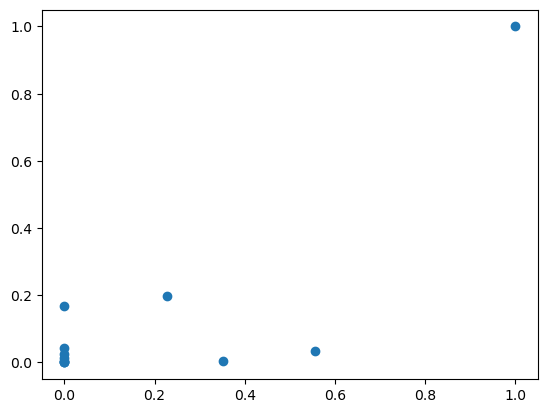

In [68]:
import matplotlib.pyplot as plt

scaler = MinMaxScaler()

MI_scaled = scaler.fit_transform(MI.reshape(-1,1))
chi_2_val_scaled = scaler.fit_transform(chi_2_val.reshape(-1,1))

plt.scatter(MI_scaled, chi_2_val_scaled)

In [ ]:
MI_scaled, chi_2_val_scaled

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")


(array([2.29625618e+02, 9.97706962e+00, 4.52353967e+01, 9.14584790e-01,
        3.86629258e+01, 2.27751821e-03, 3.29116675e+00, 1.29551336e+00,
        2.86650548e-01]),
 array([7.19431302e-52, 1.58501736e-03, 1.74718495e-11, 3.38900858e-01,
        5.03685915e-10, 9.61936724e-01, 6.96535100e-02, 2.55034390e-01,
        5.92374976e-01]))

In [70]:
arguments = [0, '/home/tristan/Desktop/Repos/DreamHF']
root = arguments[1]

outdir = root + "/output/"
risk_scores_train = pd.read_csv(outdir + "scores_train.csv")

harrell_C_training = concordance_index_censored(
            y_train['Event'], y_train['Event_time'], risk_scores_train)

result = {
    "Harrell C": [harrell_C_training]
}

print(pd.DataFrame(result, index=["train"]))


[autoreload of pipeline failed: Traceback (most recent call last):
  File "/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/tristan/Desktop/Repos/DreamHF/src/pipeline.py", line 40
    def

FileNotFoundError: [Errno 2] No such file or directory: '/home/tristan/Desktop/Repos/DreamHF/output/scores_train.csv'

In [7]:
# importing metrics
import numpy as np
from optuna import create_study
from optuna.samplers import TPESampler
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.utils import estimator_html_repr
from sklearn.utils.validation import check_is_fitted
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis, IPCRidge
from sksurv.metrics import concordance_index_censored
from xgbse import XGBSEStackedWeibull
from xgbse.converters import convert_y
from xgbse.metrics import concordance_index

from xgboost_wrapper import XGBSurvival
from survival_models import EarlyStoppingMonitor
 

In [8]:
from survival_models import CoxPH

model = CoxPH(n_taxa)
model.pipeline.fit(X_train, y_train)

model = model.cross_validation(X_train, y_train, 10)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough
[CV 1/5; 1/10] END estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough;, score=0.666 total time=   0.5s
[CV 2/5; 1/10] START estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough
[CV 2/5; 1/10] END estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough;, score=0.653 total time=   0.4s
[CV 3/5; 1/10] START estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough
[CV 3/5; 1/10] END estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough;, score=0.700 total time=   0.4s
[CV 4/5; 1/10] START estimator__alpha=0.5488135039273248, estimator__n_iter=197, pca_transformer__reduce_dim=passthrough

In [9]:
model.evaluate(X_train, X_test, y_train, y_test)


       Harrell C
train   0.731255
test    0.694139


In [10]:
from survival_models import sksurv_gbt 
model = sksurv_gbt()

model = model.cross_validation(X_train, y_train, 3)
model.evaluate(X_train, X_test, y_train, y_test)


TypeError: sksurv_gbt.__init__() missing 1 required positional argument: 'n_taxa'

In [11]:
model.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b484077f0>),
                                                 ('cat',
                                                  Pipeline(steps=[('frequent_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b48405210>)])),
                ('pca_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reduce_dim', PCA(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b48404a00>)])),
                ('estimator', CoxPHSurvivalAnalysis()),
                ('risk_scaler', MinMaxScaler())])

In [ ]:
model.pipeline[:-1]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f70a44fe200>),
                                                 ('cat',
                                                  Pipeline(steps=[('frequent_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f70a44fe3b0>)])),
                ('pca_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reduce_dim', PCA(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f70a44fe320>)]))])

In [32]:
preprocessed = model.pipeline[:-2].fit_transform(X_train)

In [36]:
preprocessed.to_numpy().shape

(3557, 10)

In [34]:
np.linalg.det(preprocessed.to_numpy())

LinAlgError: Last 2 dimensions of the array must be square

In [7]:
"""
self.base_params = {
            "objective": "survival:aft",
            "eval_metric": "aft-nloglik",
            "aft_loss_distribution": "normal",
            "aft_loss_distribution_scale": 1.20,
            "tree_method": "hist",
            "booster": "dart",
            "learning_rate": 0.032833188230587194,
            "max_depth": 3,
            "subsample": 0.61828926669036,
            "alpha": 0.012673256334558281,
            "lambda": 6.468264510932119,
            "verbosity": 0,
            #"n_estimators": 100
        }
"""

'\nself.base_params = {\n            "objective": "survival:aft",\n            "eval_metric": "aft-nloglik",\n            "aft_loss_distribution": "normal",\n            "aft_loss_distribution_scale": 1.20,\n            "tree_method": "hist",\n            "booster": "dart",\n            "learning_rate": 0.032833188230587194,\n            "max_depth": 3,\n            "subsample": 0.61828926669036,\n            "alpha": 0.012673256334558281,\n            "lambda": 6.468264510932119,\n            "verbosity": 0,\n            #"n_estimators": 100\n        }\n'

In [8]:
class xgb_aft(sksurv_model):
    def __init__(self):
        super().__init__()
         
        self.base_params = {'verbosity': 0,
                            'objective': 'survival:aft',
                            'eval_metric': 'aft-nloglik',
                            'tree_method': 'hist',
                            'learning_rate': 0.05,
                            'aft_loss_distribution': 'normal',
                            'aft_loss_distribution_scale': 1.20,
                            'max_depth': 6,
                            'lambda': 0.01,
                            'alpha': 0.02}

        self.estimator = XGBSurvival(self.base_params, num_boost_round=10000, early_stopping_rounds= 50)

        self.pipeline = self.create_pipeline()

        
        self.distributions = dict(
            reduce_dim=['passthrough', PCA(0.95), PCA(0.98)],
            estimator__learning_rate=uniform(loc=0, scale=0.2),
            estimator__max_depth=randint(3,6),
            estimator__alpha=uniform(loc=0, scale=0.2),
            estimator__lembda=uniform(loc=0, scale=0.2)
        )
        

In [9]:
model = xgb_aft()

In [11]:
model.pipeline = model.cross_validation(X_train, y_train, 3)

KeyError: 'handle'

In [26]:
model.pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f265ad32080>),
                                                 ('cat',
                                                  Pipeline(steps=[('frequent_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f265ad32ec0>)])),
                ('pca_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reduce_dim', PCA(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f265ad33dc0>)])),
                ('estimator',
                 <xgboost_wrapper.XGBSurvival object at 0x7f26bfb17580>)])

In [ ]:
model.pipeline

In [22]:
from survival_models import bind
evaluate_model(model.pipeline, X_train, X_test, y_train, y_test)

,Harrell C,Concordance index IPCW
train,0.982062,0.976392
test,0.577541,0.538264


## Sksurv gbt


In [ ]:
model = sksurv_gbt()
model.estimator = GradientBoostingSurvivalAnalysis(loss = 'ipcwls',
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
model.pipeline = model.create_pipeline()

In [ ]:

model.pipeline.fit(X_train, y_train)


In [ ]:
from ray.tune.sklearn import TuneGridSearchCV
from ray.tune.sklearn import TuneSearchCV

In [ ]:

from ray import tune
from sklearn import model_selection
from ray.tune.schedulers import HyperBandScheduler
from ray.tune.sklearn import TuneGridSearchCV
from ray.tune.sklearn import TuneSearchCV

class candidate_model:
    def __init__(self):
        self.monitor = None
        self.with_pca = False

    def cross_validation(self, X_train, y_train, n_iter):
        randsearchcv = RandomizedSearchCV(
            self.pipeline,
            self.distributions,
            random_state=0,
            n_iter=n_iter,
            n_jobs=-1,
            verbose=10,
            error_score='raise'
        )
        self.pipeline = randsearchcv.fit(X_train, y_train)
        return self
    
    def evaluate(self, X_train, X_test, y_train, y_test):
        """
        self.harrell_C_training = self.estimator.score(X_train, y_train)
        self.harrell_C_test = self.estimator.score(X_test, y_test)
        """
        self.harrell_C_training = concordance_index_censored(
            y_train['Event'], y_train['Event_time'], self.risk_score(X_train))[0]
        self.harrell_C_test = concordance_index_censored(
            y_test['Event'], y_test['Event_time'], self.risk_score(X_test))[0]

        return self

    def create_pipeline(self):
        numeric_transformer = Pipeline(
            steps=[
                ("mean_imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler()),
            ]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("frequent_imputer", SimpleImputer(strategy="most_frequent")),
            ]
        )

        pca_transformer = ColumnTransformer(
            transformers=[("reduce_dim", PCA(), selector(pattern="k__"))], remainder='passthrough')

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, selector(
                    dtype_exclude=["bool", "category", "Int64"])),
                ("cat", categorical_transformer, selector(
                    dtype_include=["bool", "category", "Int64"])),
            ]
        )

        regressor = Pipeline(
            steps=[("preprocessor", preprocessor), ("pca_transformer", pca_transformer), ("estimator", self.estimator)])

        with open("regressor.html", "w") as f:
            f.write(estimator_html_repr(regressor))

        return regressor

class sksurv_model(candidate_model):
    def __init__(self):
        super().__init__()
        self.monitor = EarlyStoppingMonitor(25, 50)
                
    def risk_score(self, X_test):
        predictions = self.pipeline.predict(X_test)  # Predict the risk score
        scaler = MinMaxScaler()
        risk_score = scaler.fit_transform(predictions.reshape(-1, 1))
        #The range of this number has to be between 0 and 1, with larger numbers being associated with higher probability of having HF. The values, -Inf, Inf and NA, are not allowed.
        return risk_score.to_numpy().flatten()
    
class sksurv_gbt(sksurv_model):
    def __init__(self):
        super().__init__()
         
        self.estimator = GradientBoostingSurvivalAnalysis()
        
        self.pipeline = self.create_pipeline()

        self.distributions = dict(
            pca_transformer__reduce_dim= ['passthrough', PCA(0.95), PCA(0.98)],
            estimator__learning_rate=uniform(loc=1e-2, scale=0.4),
            estimator__max_depth=randint(2, 6),
            estimator__loss=["coxph"], #ipcwls corresponds to aft model
            estimator__n_estimators=randint(100, 350),
            estimator__min_samples_split=randint(2, 6),
            estimator__min_samples_leaf=randint(1, 10),
            estimator__subsample=uniform(loc=0.5, scale=0.5),
            estimator__max_leaf_nodes=randint(2, 30),
            estimator__dropout_rate=uniform(loc=0, scale=0.5)
        )

In [ ]:
model = sksurv_gbt()
model.cross_validation(X_train, y_train, 10)

In [ ]:
model = sksurv_gbt()
model.raytune_optimization(X_train, y_train, 10)

In [ ]:
from ray import tune
from sklearn import model_selection
from ray.tune.schedulers import HyperBandScheduler

# 1. Define an objective function.


model = sksurv_gbt()
def objective(config):
    
    model.pipeline.set_params(**config)
    score = model_selection.cross_val_score(model.pipeline, X_train, y_train, n_jobs=1, cv=3)
        
    return {"score": score}


# 2. Define a search space.
search_space = {
    "aft_loss_distribution_scale": tune.grid_search([0.1, 1, 10]),
}
 
# Create HyperBand scheduler and minimize the score
hyperband = HyperBandScheduler(metric="score", mode="max")

# 3. Start a Tune run and print the best result.
tuner = tune.Tuner(objective, tune_config=tune.TuneConfig(
    num_samples=20,
    scheduler=hyperband,
), param_space=search_space)
results = tuner.fit()
print(results.get_best_result(metric="score", mode="max", filter_nan_and_inf = False).config)


In [ ]:
def cross_validation(self, X_train, y_train, n_iter):
        randsearchcv = RandomizedSearchCV(
            self.pipeline,
            self.distributions,
            random_state=0,
            n_iter=n_iter,
            n_jobs=4,
            verbose=10,
            error_score='raise'
        )
        self.pipeline = randsearchcv.fit(X_train, y_train)
        return self

In [ ]:
class sksurv_model(candidate_model):
    def __init__(self):
        super().__init__()
        self.monitor = EarlyStoppingMonitor(25, 50)

    def risk_score(self, X_test):
        predictions = self.pipeline.predict(X_test)  # Predict the risk score
        scaler = MinMaxScaler()
        risk_score = scaler.fit_transform(predictions.reshape(-1, 1))
        #The range of this number has to be between 0 and 1, with larger numbers being associated with higher probability of having HF. The values, -Inf, Inf and NA, are not allowed.
        return risk_score.to_numpy().flatten()


class sksurv_gbt(sksurv_model):
    def __init__(self):
        super().__init__()

        self.estimator = GradientBoostingSurvivalAnalysis()
        
        self.pipeline = self.create_pipeline()

        self.distributions = dict(
            pca_transformer__reduce_dim= ['passthrough', PCA(0.95), PCA(0.98)], #uniform(loc=0.95, scale=0.05), #
            learning_rate=uniform(loc=1e-2, scale=0.4),
            max_depth=randint(2, 6),
            estimator__loss=["coxph", "ipcwls"],
            n_estimators=randint(100, 350),
            min_samples_split=randint(2, 6),
            min_samples_leaf=randint(1, 10),
            subsample=uniform(loc=0.5, scale=0.5),
            max_leaf_nodes=randint(2, 30),
            estimator__dropout_rate=uniform(loc=0, scale=1),
        )


In [ ]:
def cross_validation_score(pipeline, X_train, y_train, n_splits=3, n_repeats=1, early_stopping_rounds=50):
    # Compute the cross-validation score, works with pandas dataframe (the sklearn function does not)

    rkf = RepeatedKFold(
          n_splits=n_splits, n_repeats=n_repeats, random_state=0
          )
    score = 0
    for train_index, test_index in rkf.split(X_train):
        X_A, X_B = X_train.iloc[train_index,
                                :], X_train.iloc[test_index, :]
        y_A, y_B = y_train[train_index], y_train[test_index]

        if not check_is_fitted(pipeline):
            pipeline[:-1].fit(X_A, y_A)

        X_B_transformed = pipeline.estimator.named_steps['preprocessor'].transform(
            X_B)

        pipeline.fit(
            X_A,
            y_A,
            estimator__validation_data=(X_B_transformed, y_B),
            estimator__verbose_eval=0,
            estimator__early_stopping_rounds=early_stopping_rounds
        )
        score += pipeline.score(X_B, y_B)
    score /= (n_repeats*n_splits)
    return score


In [ ]:

def xgb_cross_validation_score(pipeline, X_train, y_train, n_splits=3, n_repeats=1, early_stopping_rounds=50):
    # Compute the cross-validation score, works with pandas dataframe (the sklearn function does not)

    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=0
    )
    score = 0
    for train_index, test_index in rkf.split(X_train):
        X_A, X_B = X_train.iloc[train_index,
                                :], X_train.iloc[test_index, :]
        y_A, y_B = y_train[train_index], y_train[test_index]

        pipeline[:-1].fit(X_A, y_A)

        X_B_transformed = pipeline[:-1].transform(
            X_B)

        pipeline.fit(
            X_A,
            y_A,
            estimator__validation_data=(X_B_transformed, y_B),
            estimator__verbose_eval=0,
            estimator__early_stopping_rounds=early_stopping_rounds
        )
        score += pipeline.score(X_B, y_B)
    score /= (n_repeats*n_splits)
    return score


In [ ]:
from sklearn import model_selection
from survival_models import candidate_model

In [ ]:
class xgb_optuna(candidate_model):
    def __init__(self):
        super().__init__()
        # repeated K-folds
        self.N_SPLITS = 3
        self.N_REPEATS = 1

        # Optuna 
        self.RS = 124  # random state
        # XGBoost
        self.EARLY_STOPPING_ROUNDS = 50
        self.MULTIVARIATE = True

        self.sampler = TPESampler(seed=self.RS, multivariate=self.MULTIVARIATE)
        self.base_params = {
            "objective": "survival:aft",
            "eval_metric": "aft-nloglik",
            "aft_loss_distribution": "normal",
            "aft_loss_distribution_scale": 1.20,
            "tree_method": "hist",
            "booster": "dart",
            "learning_rate": 0.032833188230587194,
            "max_depth": 10,
            "subsample": 0.61828926669036,
            "alpha": 0.012673256334558281,
            "lambda": 6.468264510932119,
            "verbosity": 0,
            "n_estimators": 10000,
            "seed": self.RS,
        }

        self.estimator = XGBSurvival(self.base_params, num_boost_round=10000)
        self.pipeline = self.create_pipeline()

    def cross_validation(self, X_train, y_train, n_iter):
        study = create_study(direction="maximize", sampler=self.sampler)
        study.optimize(
            lambda trial: self.objective(
                trial,
                X_train,
                y_train
            ),
            n_trials=n_iter,
            n_jobs=1,
        )
        self.optimal_hp = study.best_params
        self.pipeline.set_params(**self.optimal_hp)
        self.pipeline = self.pipeline.fit(X_train, y_train)
        return self

    def objective(
        self,
        trial,
        X_train,
        y_train
        ):
        # XGBoost parameters

        xgb_params = {
            "objective": "survival:aft",
            "eval_metric": "aft-nloglik",
            "aft_loss_distribution": "normal",
            "aft_loss_distribution_scale": trial.suggest_float('aft_loss_distribution_scale', 0.1, 10.0, log=True),
            "tree_method": "hist",
            "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 12),
            "booster": "dart",
            "subsample": trial.suggest_float("subsample", 0.4, 0.8, log=False),
            "alpha": trial.suggest_float("alpha", 0.01, 10.0, log=True),
            "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
            "gamma": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        }
        pipeline_params = {"pca_transformer__reduce_dim": trial.suggest_categorical("pca_transformer__reduce_dim", ['passthrough', PCA(0.95), PCA(0.98)])}

        self.estimator = XGBSurvival(xgb_params, num_boost_round=10000)
        self.pipeline = self.create_pipeline()
        self.pipeline.set_params(**pipeline_params)
        
        self.estimator = XGBSurvival(params, num_boost_round=10000)
        self.pipeline = self.create_pipeline()
        #score = model_selection.cross_val_score(self.pipeline, X_train, y_train, n_jobs=1, cv=3)
        score = xgb_cross_validation_score(self.pipeline, X_train, y_train)
        accuracy = score.mean()
        return accuracy    

    def risk_score(self, X_test):
        risk_score =  xgb_risk_score(self, X_test)
        return risk_score
    

In [ ]:
model = xgb_optuna()
model = model.cross_validation(X_train, y_train,3)

In [ ]:
score = xgb_cross_validation_score(self.pipeline, X_train, y_train)

In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedKFold
            
# define search space
params = dict()
params['estimator__learning_rate'] = (1e-2, 0.4, 'uniform')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = BayesSearchCV(estimator=model.pipeline, search_spaces=params, n_jobs=-1, cv= cv)
search.fit(X_train, y_train)

## Try Raytune

In [ ]:
xgb_params = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": trial.suggest_float('aft_loss_distribution_scale', 0.1, 10.0, log=True),
    "tree_method": "hist",
    "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1, log=True),
    "max_depth": trial.suggest_int("max_depth", 2, 12),
    "booster": "dart",
    "subsample": trial.suggest_float("subsample", 0.4, 0.8, log=False),
    "alpha": trial.suggest_float("alpha", 0.01, 10.0, log=True),
    "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
    "gamma": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
}
pipeline_params = {"pca_transformer__reduce_dim": trial.suggest_categorical(
    "pca_transformer__reduce_dim", ['passthrough', PCA(0.95), PCA(0.98)])}


In [ ]:
from ray import tune

# 1. Define an objective function.


def objective(config):
    score = config["a"] ** 2 + config["b"]
    return {"score": score}


# 2. Define a search space.
search_space = {
    "aft_loss_distribution_scale": tune.grid_search([0.1, 1, 10]),
    "b": tune.choice([1, 2, 3]),
}

# 3. Start a Tune run and print the best result.
tuner = tune.Tuner(objective, param_space=search_space)
results = tuner.fit()
print(results.get_best_result(metric="score", mode="min").config)
